## Setup

This notebook used the `bash` kernel

    conda activate ciao
    pip3 install bash_kernel
    python -m bash_kernel.install --sys-prefix
    

In [1]:
ciaover -v
check_ciao_caldb

# packages in environment at /soft/miniconda/envs/ciao:
#
# Name                    Version                   Build  Channel
ciao                      4.13.0           py38h5ec60c1_0    https://cxc.cfa.harvard.edu/conda/test
ciao-contrib              4.13.0                     py_4    https://cxc.cfa.harvard.edu/conda/test
ds9                       8.2                           2    https://cxc.cfa.harvard.edu/conda/test
sherpa                    4.13.0           py38h5ec60c1_0    https://cxc.cfa.harvard.edu/conda/test
zciao                     4.13.1                        4    https://hea-www.harvard.edu/~kjg/ciao

System information:
Linux kjg-XPS-8940 5.8.0-41-generic #46~20.04.1-Ubuntu SMP Mon Jan 18 17:52:23 UTC 2021 x86_64 x86_64 x86_64 GNU/Linux
CALDB environment variable = /soft/miniconda/envs/ciao/CALDB
             CALDB version = 4.9.4
             release date  = 2020-12-15T16:00:00 UTC
CALDB query completed successfully.


## Surrogate dataset



In [2]:
/bin/rm -rf 6676
download_chandra_obsid 6676 evt2,asol,bpix,msk


  Type     Format      Size  0........H.........1  Download Time Average Rate
  ---------------------------------------------------------------------------
  evt2     fits        9 Mb  ####################            5 s  1851.6 kb/s
  asol     fits        7 Mb  ####################            3 s  2742.6 kb/s
  bpix     fits        4 Kb  ####################          < 1 s  39.7 kb/s
  msk      fits        4 Kb  ####################          < 1 s  38.3 kb/s

      Total download size for ObsId 6676 = 16 Mb
      Total download time for ObsId 6676 = 8 s



In [3]:
evt=`/bin/ls 6676/primary/*evt2.fits.gz`

In [4]:
dmlist $evt header,clean | grep ^SIM

SIM_X                   -0.68282252473119 [mm]      SIM focus pos
SIM_Y                                   0 [mm]      SIM orthogonal axis pos
SIM_Z                     -180.4674950848 [mm]      SIM translation stage pos


### Pick region

Load evts into ds9, draw region at expected location, and save it, eg to `ds9.reg`.

In [5]:
# load into ds9, draw & save region
ds9 $evt

In [6]:
cat ds9.reg

# Region file format: DS9 version 4.1
global color=green dashlist=8 3 width=1 font="helvetica 10 normal roman" select=1 highlite=1 dash=0 fixed=0 edit=1 move=1 delete=1 include=1 source=1
fk5
box(18:52:38.6058,+0:40:19.894,2.407",3.269",333.42087)


### Run `specextract` 

In [7]:
punlearn specextract
specextract infile="${evt}[sky=region(ds9.reg)]" \
  out=cuckoo weight=yes mode=h clob+ 

Running specextract
Version: 8 December 2020

Using event file 6676/primary/acisf06676N003_evt2.fits.gz[sky=region(ds9.reg)]

Aspect solution file 6676/primary/pcadf06676_000N001_asol1.fits found.

Bad-pixel file 6676/primary/acisf06676_000N003_bpix1.fits.gz found.

Mask file 6676/secondary/acisf06676_000N003_msk1.fits found.

Setting bad pixel file 

Extracting src spectra 

Creating src ARF 

Creating src RMF 

Using mkacisrmf...

Grouping src spectrum 

Updating header of cuckoo.pi with RESPFILE and ANCRFILE keywords.

Updating header of cuckoo_grp.pi with RESPFILE and ANCRFILE keywords.



---

## Make future ARF

Okay, now we need to create the future ARF file.  This takes 3 steps

- run `asphist` to create aspect histogram
- run `sky2tdet` to create the weight map.
- run `mkwarf` to create the ARF.

### First things first,

We need to be sure that we have the `ardlib.par` file setup with the correct bad pixel file.  Probably won't really matter, but we might as well do it right.  (We of course will not know the future badpixel file since it's different for each observation; but 
generally not significantly.)




In [8]:
punlearn ardlib
acis_set_ardlib 6676/primary/acisf06676*_bpix1.fits.gz abs-

Updated ardlib parameter file: /home/kjg/cxcds_param4/ardlib.par
  AXAF_ACIS0_BADPIX_FILE -> CALDB
  AXAF_ACIS1_BADPIX_FILE -> CALDB
  AXAF_ACIS2_BADPIX_FILE -> CALDB
  AXAF_ACIS3_BADPIX_FILE -> CALDB
  AXAF_ACIS4_BADPIX_FILE -> CALDB
  AXAF_ACIS5_BADPIX_FILE -> CALDB
  AXAF_ACIS6_BADPIX_FILE -> CALDB
  AXAF_ACIS7_BADPIX_FILE -> 6676/primary/acisf06676_000N003_bpix1.fits.gz[BADPIX7]
  AXAF_ACIS8_BADPIX_FILE -> CALDB
  AXAF_ACIS9_BADPIX_FILE -> CALDB


### Make the aspect histogram

In [9]:
punlearn asphist
asphist in= 6676/primary/*_asol1.fits.gz \
  out=asp.hist evt=$evt mode=h clob+

### Make the WMAP 

In [10]:
punlearn sky2tdet
sky2tdet infile="${evt}[sky=region(ds9.reg),energy=500:7000]" \
  asphist=asp.hist outfile="cuckoo.wmap[wmap]" clob+

In [11]:
###ds9 cuckoo.wmap

### Make the weighted ARF.

One short cut we can take since we already have the ARF from running `specextract`
is to use the `dmhistory` tool to `pset` all the tools parameters.

> Note: you can ignore the `"ardlib" library parameters` warnings below.

In [12]:
dmhistory cuckoo.arf mkwarf action=get | sed s,`pwd`/,,g

# dmhistory (CIAO 4.13): WARNING: Found and corrected "ardlib" library parameters

mkwarf infile="/tmp/tmp66n5zzt5_tdet[wmap]" outfile="cuckoo.arf" weightfile="/tmp/tmp7xsxjf23.wfef" spectrumfile="" egridspec="0.3:11.0:0.01" pbkfile="" threshold="0" feffile="CALDB" mskfile="6676/secondary/acisf06676_000N003_msk1.fits" asolfile="" mirror="HRMA" detsubsysmod="" dafile="CALDB" ardlibpar="ardlib" geompar="geom" clobber="yes" verbose="1" 



Now same thing, but with `action=pset`

In [13]:
punlearn mkwarf
dmhistory cuckoo.arf mkwarf action=pset 
pdump mkwarf | sed s,`pwd`/,,g

# dmhistory (CIAO 4.13): WARNING: Found and corrected "ardlib" library parameters

infile='/tmp/tmp66n5zzt5_tdet[wmap]'
outfile='cuckoo.arf'
weightfile='/tmp/tmp7xsxjf23.wfef'
spectrumfile=''
egridspec='0.3:11.0:0.01'
pbkfile=''
threshold='0'
feffile='CALDB'
mskfile='6676/secondary/acisf06676_000N003_msk1.fits'
asolfile=''
mirror='HRMA'
detsubsysmod=''
dafile='CALDB'
ardlibpar='ardlib'
geompar='geom'
clobber='yes'
verbose='1'
mode='ql'
# EOF


Okay, now we need to pick our future date and convert to Chandra mission time

In [14]:
# Pick a date in the future, eg 2021-05-15

prop_dates from UTC to CHANDRA p0 eval 2021 05 15
newtime=$(prop_dates from UTC to CHANDRA p0 eval 2021 05 15)

737424006


Okay, we are now ready run `mkwarf` to generate our future ARF:

In [15]:
pset mkwarf infile="cuckoo.wmap"
pset mkwarf detsubsysmod="TIME=$newtime"

In [16]:
mkwarf outfile=new_cuckoo.arf weight=new_cuckoo.wfef mode=h clob+ | sed s,`pwd`/,,g

# mkwarf (CIAO 4.13): WARNING: 'CYCLE' keyword not found in file 'cuckoo.wmap'; assuming CC-mode

Parameters for mkwarf:
  infile              = cuckoo.wmap
  outfile             = new_cuckoo.arf
  weightfile          = new_cuckoo.wfef
  feffile             = CALDB
  egridspec           = 0.3:11.0:0.01
  spectrumfile        = 
  threshold           = 0
  asolfile            = 
  mirror              = HRMA
  ardlibpar           = ardlib
  pbkfile             = 
  mskfile             = 6676/secondary/acisf06676_000N003_msk1.fits
  detsubsysmod        = TIME=737424006
  dafile              = CALDB
  geompar             = geom
  clobber             = yes
  verbose             = 1


## Compare now and later

We can use `dmdiff` to see the difference in the effective area (`specresp`) between the two files.

In [18]:
dmdiff cuckoo.arf new_cuckoo.arf || echo 

Infile 1:  cuckoo.arf
Infile 2:  new_cuckoo.arf

-----------------------
HEADER VALUE DIFFERENCES
-----------------------


Message:                                Keyword:              Value(s):                    Diff:
--------                                 -------              ---------                    -----
Values are not equal                    CHECKSUM bGAJcF99bFAGbF99  Bpp3Cmm2Bmm2Bmm2
# dmdiff (CIAO 4.13): WARNING: CHECKSUM comments are different.
# dmdiff (CIAO 4.13):   comment1= "HDU checksum updated 2021-02-03T20:26:48"
# dmdiff (CIAO 4.13):   comment2= "HDU checksum updated 2021-02-03T20:26:54"
Values are not equal                     DATASUM       3707797084  2852913944      
# dmdiff (CIAO 4.13): WARNING: DATASUM comments are different.
# dmdiff (CIAO 4.13):   comment1= "data unit checksum updated 2021-02-03T20:26:48"
# dmdiff (CIAO 4.13):   comment2= "data unit checksum updated 2021-02-03T20:26:54"
Values are not equal                        DATE 2021-02-03T20:26:4

Values are not equal                  57        SPECRESP 373.685638427734  27.6243877410889     -346.061 (-92.6 %)
Values are not equal                  58        SPECRESP 381.972778320312  30.4599800109863     -351.513 (  -92 %)
Values are not equal                  59        SPECRESP 389.933044433594  33.3898429870605     -356.543 (-91.4 %)
Values are not equal                  60        SPECRESP 397.396148681641  36.3352737426758     -361.061 (-90.9 %)
Values are not equal                  61        SPECRESP 404.520080566406  39.4094696044922     -365.111 (-90.3 %)
Values are not equal                  62        SPECRESP 411.096435546875  42.6651268005371     -368.431 (-89.6 %)
Values are not equal                  63        SPECRESP 417.632781982422  46.1272811889648     -371.505 (  -89 %)
Values are not equal                  64        SPECRESP 423.988983154297  49.6634902954102     -374.326 (-88.3 %)
Values are not equal                  65        SPECRESP 430.607574462891  53.42

Values are not equal                 129        SPECRESP 581.804931640625  345.651611328125     -236.153 (-40.6 %)
Values are not equal                 130        SPECRESP 572.301330566406  343.201934814453     -229.099 (  -40 %)
Values are not equal                 131        SPECRESP 577.195129394531  349.391296386719     -227.804 (-39.5 %)
Values are not equal                 132        SPECRESP 588.758483886719  359.685668945312     -229.073 (-38.9 %)
Values are not equal                 133        SPECRESP 585.951965332031  361.161071777344     -224.791 (-38.4 %)
Values are not equal                 134        SPECRESP  582.40771484375  361.78466796875      -220.623 (-37.9 %)
Values are not equal                 135        SPECRESP 585.413818359375  366.447143554688     -218.967 (-37.4 %)
Values are not equal                 136        SPECRESP 590.666748046875  372.540771484375     -218.126 (-36.9 %)
Values are not equal                 137        SPECRESP 593.368957519531  377.0

Values are not equal                 201        SPECRESP 370.123626708984  308.915588378906      -61.208 (-16.5 %)
Values are not equal                 202        SPECRESP 371.085235595703  310.406646728516     -60.6786 (-16.4 %)
Values are not equal                 203        SPECRESP 369.444702148438  309.680755615234     -59.7639 (-16.2 %)
Values are not equal                 204        SPECRESP 373.256103515625  313.529846191406     -59.7263 (  -16 %)
Values are not equal                 205        SPECRESP 378.321166992188  318.448974609375     -59.8722 (-15.8 %)
Values are not equal                 206        SPECRESP 381.366577148438  321.683654785156     -59.6829 (-15.6 %)
Values are not equal                 207        SPECRESP 385.787261962891  326.09326171875       -59.694 (-15.5 %)
Values are not equal                 208        SPECRESP 387.647430419922  328.349212646484     -59.2982 (-15.3 %)
Values are not equal                 209        SPECRESP 387.200347900391  328.6

Values are not equal                 273        SPECRESP 410.126678466797  377.769165039062     -32.3575 (-7.89 %)
Values are not equal                 274        SPECRESP 410.605621337891  378.493560791016     -32.1121 (-7.82 %)
Values are not equal                 275        SPECRESP 411.056121826172  379.160614013672     -31.8955 (-7.76 %)
Values are not equal                 276        SPECRESP 411.571197509766  379.878479003906     -31.6927 ( -7.7 %)
Values are not equal                 277        SPECRESP 411.892822265625  380.418518066406     -31.4743 (-7.64 %)
Values are not equal                 278        SPECRESP 412.103607177734  380.856658935547     -31.2469 (-7.58 %)
Values are not equal                 279        SPECRESP 412.348541259766  381.326721191406     -31.0218 (-7.52 %)
Values are not equal                 280        SPECRESP 412.709869384766  381.9052734375       -30.8046 (-7.46 %)
Values are not equal                 281        SPECRESP 413.127502441406  382.5

Values are not equal                 345        SPECRESP 423.904174804688  405.647216796875      -18.257 (-4.31 %)
Values are not equal                 346        SPECRESP  423.74462890625  405.603607177734      -18.141 (-4.28 %)
Values are not equal                 347        SPECRESP 423.618774414062  405.591857910156     -18.0269 (-4.26 %)
Values are not equal                 348        SPECRESP 423.492248535156  405.579925537109     -17.9123 (-4.23 %)
Values are not equal                 349        SPECRESP 423.392059326172  405.593322753906     -17.7987 ( -4.2 %)
Values are not equal                 350        SPECRESP 423.291961669922  405.606567382812     -17.6854 (-4.18 %)
Values are not equal                 351        SPECRESP 423.130584716797  405.560760498047     -17.5698 (-4.15 %)
Values are not equal                 352        SPECRESP 422.907806396484  405.45654296875      -17.4513 (-4.13 %)
Values are not equal                 353        SPECRESP 422.685150146484  405.3

Values are not equal                 417        SPECRESP 397.428436279297  386.950103759766     -10.4783 (-2.64 %)
Values are not equal                 418        SPECRESP 396.597473144531  386.223052978516     -10.3744 (-2.62 %)
Values are not equal                 419        SPECRESP 395.906341552734  385.632049560547     -10.2743 ( -2.6 %)
Values are not equal                 420        SPECRESP 395.215667724609  385.040985107422     -10.1747 (-2.57 %)
Values are not equal                 421        SPECRESP 394.487823486328  384.413604736328     -10.0742 (-2.55 %)
Values are not equal                 422        SPECRESP 393.723205566406  383.749816894531     -9.97339 (-2.53 %)
Values are not equal                 423        SPECRESP 392.959136962891  383.086639404297      -9.8725 (-2.51 %)
Values are not equal                 424        SPECRESP 392.211151123047  382.438842773438     -9.77231 (-2.49 %)
Values are not equal                 425        SPECRESP 391.463439941406  381.7

Values are not equal                 489        SPECRESP 318.656311035156  314.12646484375      -4.52985 (-1.42 %)
Values are not equal                 490        SPECRESP 317.241363525391  312.766723632812     -4.47464 (-1.41 %)
Values are not equal                 491        SPECRESP 315.828857421875  311.408935546875     -4.41992 ( -1.4 %)
Values are not equal                 492        SPECRESP 314.418151855469  310.052947998047      -4.3652 (-1.39 %)
Values are not equal                 493        SPECRESP 313.010406494141  308.699462890625     -4.31094 (-1.38 %)
Values are not equal                 494        SPECRESP 311.513122558594  307.256744384766     -4.25638 (-1.37 %)
Values are not equal                 495        SPECRESP 310.018371582031  305.817260742188     -4.20111 (-1.36 %)
Values are not equal                 496        SPECRESP 308.549072265625  304.401885986328     -4.14719 (-1.34 %)
Values are not equal                 497        SPECRESP 307.105072021484  303.0

Values are not equal                 561        SPECRESP 220.024398803711  218.019744873047     -2.00465 (-0.911 %)
Values are not equal                 562        SPECRESP 219.134368896484  217.144515991211     -1.98985 (-0.908 %)
Values are not equal                 563        SPECRESP 218.246520996094  216.271011352539     -1.97551 (-0.905 %)
Values are not equal                 564        SPECRESP 216.990417480469  215.032913208008      -1.9575 (-0.902 %)
Values are not equal                 565        SPECRESP 215.737808227539  213.798095703125     -1.93971 (-0.899 %)
Values are not equal                 566        SPECRESP 214.547149658203  212.624755859375     -1.92239 (-0.896 %)
Values are not equal                 567        SPECRESP 213.418395996094  211.512313842773     -1.90608 (-0.893 %)
Values are not equal                 568        SPECRESP 212.292419433594  210.40266418457      -1.88976 (-0.89 %)
Values are not equal                 569        SPECRESP 211.151336669922

Values are not equal                 632        SPECRESP 144.495788574219  143.480377197266     -1.01541 (-0.703 %)
Values are not equal                 633        SPECRESP 143.437164306641  142.433029174805     -1.00414 ( -0.7 %)
Values are not equal                 634        SPECRESP 142.341598510742  141.349136352539    -0.992462 (-0.697 %)
Values are not equal                 635        SPECRESP 141.244323730469  140.263305664062    -0.981018 (-0.695 %)
Values are not equal                 636        SPECRESP 140.178070068359  139.208267211914    -0.969803 (-0.692 %)
Values are not equal                 637        SPECRESP 139.142715454102  138.183807373047    -0.958908 (-0.689 %)
Values are not equal                 638        SPECRESP 138.110778808594  137.162750244141    -0.948029 (-0.686 %)
Values are not equal                 639        SPECRESP 136.985977172852  136.049407958984    -0.936569 (-0.684 %)
Values are not equal                 640        SPECRESP 135.866546630859

Values are not equal                 703        SPECRESP 78.5493774414062  78.1244659423828    -0.424911 (-0.541 %)
Values are not equal                 704        SPECRESP 77.8183288574219  77.3988418579102    -0.419487 (-0.539 %)
Values are not equal                 705        SPECRESP 77.0901718139648  76.676139831543     -0.414032 (-0.537 %)
Values are not equal                 706        SPECRESP 76.3556747436523  75.9469757080078    -0.408699 (-0.535 %)
Values are not equal                 707        SPECRESP 75.6150054931641  75.211784362793     -0.403221 (-0.533 %)
Values are not equal                 708        SPECRESP 74.8772354125977  74.4793243408203    -0.397911 (-0.531 %)
Values are not equal                 709        SPECRESP 74.1934585571289  73.8005828857422    -0.392876 (-0.53 %)
Values are not equal                 710        SPECRESP  73.512336730957  73.1244506835938    -0.387886 (-0.528 %)
Values are not equal                 711        SPECRESP 72.8011169433594

Values are not equal                 774        SPECRESP 38.9978218078613  38.8390579223633    -0.158764 (-0.407 %)
Values are not equal                 775        SPECRESP 38.6464576721191  38.4898223876953    -0.156635 (-0.405 %)
Values are not equal                 776        SPECRESP 38.3155784606934  38.1609497070312    -0.154629 (-0.404 %)
Values are not equal                 777        SPECRESP 38.0049934387207  37.8523750305176    -0.152618 (-0.402 %)
Values are not equal                 778        SPECRESP 37.6954574584961  37.5447387695312    -0.150719 ( -0.4 %)
Values are not equal                 779        SPECRESP 37.3606300354004  37.2119445800781    -0.148685 (-0.398 %)
Values are not equal                 780        SPECRESP 37.0270004272461  36.8803291320801    -0.146671 (-0.396 %)
Values are not equal                 781        SPECRESP 36.7112884521484  36.5665740966797    -0.144714 (-0.394 %)
Values are not equal                 782        SPECRESP 36.4133682250977

Values are not equal                 845        SPECRESP 24.8550148010254  24.7863941192627   -0.0686207 (-0.276 %)
Values are not equal                 846        SPECRESP 24.7300624847412  24.6622371673584   -0.0678253 (-0.274 %)
Values are not equal                 847        SPECRESP 24.6026039123535  24.535587310791    -0.0670166 (-0.272 %)
Values are not equal                 848        SPECRESP 24.4754676818848  24.4092578887939   -0.0662098 (-0.271 %)
Values are not equal                 849        SPECRESP 24.3493251800537  24.2838973999023   -0.0654278 (-0.269 %)
Values are not equal                 850        SPECRESP  24.223518371582  24.1588649749756   -0.0646534 (-0.267 %)
Values are not equal                 851        SPECRESP 24.0994358062744  24.0355796813965   -0.0638561 (-0.265 %)
Values are not equal                 852        SPECRESP 23.9771003723145  23.9140014648438   -0.0630989 (-0.263 %)
Values are not equal                 853        SPECRESP 23.855068206787

Values are not equal                 916        SPECRESP 16.5028038024902  16.4735794067383   -0.0292244 (-0.177 %)
Values are not equal                 917        SPECRESP 16.3824157714844  16.3535118103027    -0.028904 (-0.176 %)
Values are not equal                 918        SPECRESP 16.2624740600586  16.2339038848877   -0.0285702 (-0.176 %)
Values are not equal                 919        SPECRESP 16.1485729217529  16.1203155517578   -0.0282574 (-0.175 %)
Values are not equal                 920        SPECRESP 16.0350856781006  16.007137298584    -0.0279484 (-0.174 %)
Values are not equal                 921        SPECRESP   15.91774559021  15.8901166915894   -0.0276289 (-0.174 %)
Values are not equal                 922        SPECRESP  15.796594619751  15.7692861557007   -0.0273085 (-0.173 %)
Values are not equal                 923        SPECRESP 15.6783514022827  15.6513633728027    -0.026988 (-0.172 %)
Values are not equal                 924        SPECRESP 15.554185867309

Values are not equal                 987        SPECRESP 6.55726909637451  6.54839944839478  -0.00886965 (-0.135 %)
Values are not equal                 988        SPECRESP 6.41920900344849  6.41055583953857  -0.00865316 (-0.135 %)
Values are not equal                 989        SPECRESP 6.28088617324829  6.27245664596558  -0.00842953 (-0.134 %)
Values are not equal                 990        SPECRESP 6.14319372177124  6.13497161865234   -0.0082221 (-0.134 %)
Values are not equal                 991        SPECRESP 6.00475740432739  5.99675273895264  -0.00800467 (-0.133 %)
Values are not equal                 992        SPECRESP  5.8656063079834  5.85781049728394  -0.00779581 (-0.133 %)
Values are not equal                 993        SPECRESP 5.72707653045654  5.71949434280396  -0.00758219 (-0.132 %)
Values are not equal                 994        SPECRESP  5.6020336151123  5.5946478843689   -0.00738573 (-0.132 %)
Values are not equal                 995        SPECRESP 5.4775438308715

Values are not equal                1058        SPECRESP 0.813520669937134  0.812485456466675  -0.00103521 (-0.127 %)
Values are not equal                1059        SPECRESP 0.791096091270447  0.790089249610901  -0.00100684 (-0.127 %)
Values are not equal                1060        SPECRESP 0.768769145011902  0.767791032791138 -0.000978112 (-0.127 %)
Values are not equal                1061        SPECRESP 0.747038066387177  0.746086835861206 -0.000951231 (-0.127 %)
Values are not equal                1062        SPECRESP 0.725874006748199  0.724950194358826 -0.000923812 (-0.127 %)
Values are not equal                1063        SPECRESP 0.704793691635132  0.703896343708038 -0.000897348 (-0.127 %)
Values are not equal                1064        SPECRESP 0.684909999370575  0.68403822183609 -0.000871778 (-0.127 %)
Values are not equal                1065        SPECRESP 0.665118217468262  0.664271473884583 -0.000846744 (-0.127 %)
Values are not equal                1066        SPECRESP 

In [19]:
##ccp cuckoo.arf

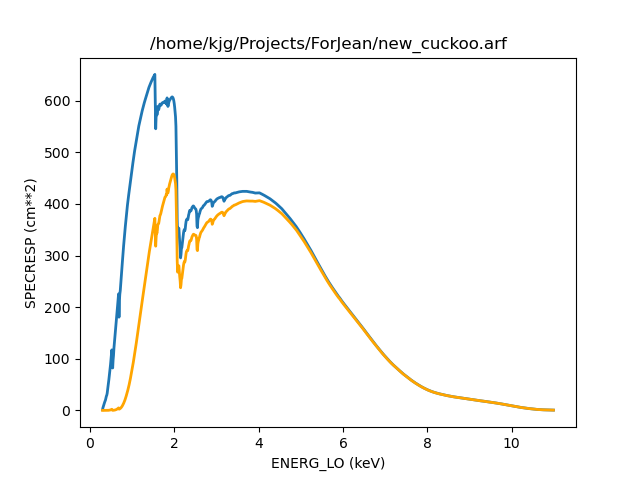

In [20]:
display < Figure_1.png

## Are we at the edge of the chip?



In [21]:
dmstat new_cuckoo.wfef"[cols chipx,chipy]" 

CHIPX(CHIPX_LO, CHIPX_HI)
    min:	( 161 192 )	      @:	( 1 1 )
    max:	( 225 256 )	      @:	( 5 5 )
   mean:	( 193 224 )
  sigma:	( 26.12789059 26.12789059 )
    sum:	( 1158 1344 )
   good:	( 6 6 )
   null:	( 0 0 )

CHIPY(CHIPY_LO, CHIPY_HI)
    min:	( 65 96 )	      @:	( 1 1 )
    max:	( 97 128 )	      @:	( 2 2 )
   mean:	( 81 112 )
  sigma:	( 16 16 )
    sum:	( 486 672 )
   good:	( 6 6 )
   null:	( 0 0 )



it looks like it.